In [1]:
import random

import numpy as np
import random
import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# number of characters in a word.
# for instance abccba has nb_chars = 6
nb_chars = 4

# number of possible characters used during the encoding.
# for instance abcde leads to 01234 has nb_letters = 5
nb_letters = 26

# number of words samples to be generated 
nb_words = 30000

# percentage of words that will be used for validation
percentage_split = 0.90

In [3]:
# total number of combinations
nb_letters**nb_chars

456976

In [4]:
def create_inputs(nb_words, nb_chars, nb_letters):
    '''Create a numpy array of nb_words rows with nb_chars columns each element
    being a random letter of nb_letters (a, b...)'''
    words = np.zeros((nb_words, nb_chars), dtype=int)
    
    for w in range(nb_words):
        optim_tentative = False
        if optim_tentative == True and w%10 != 0:
            i = random.randint(0, nb_letters-1)
            for c in range(nb_chars):
                words[w, c] = ord('a') + i
        else:
            for c in range(nb_chars):
                i = random.randint(0, nb_letters-1)
                words[w, c] = ord('a') + i
                
    return words


def encrypt(words, nb_words, nb_chars):
    '''Encrypt each element of a numpy array of nb_words rows with nb_chars 
    columns each item with a secret algorithm'''
    
    encrypted_words = words.copy()
    encrypted_words_probs = np.zeros((nb_words, nb_chars, nb_chars))
    
    #val_max = -1
    
    for w in range(nb_words):
        for c in range(nb_chars): # 0,1,2,3,4
            encrypted_words[w,c] = int(words[w,c]) - 49
            val = encrypted_words[w,c] - 48
            
            #if val > val_max:
            #    val_max = val
            
            # add entropy (i.e. mistakes in the encryption)
            #epsilon = random.randint(0, 100)
            #if epsilon == 5 and val != val_max:
            #val +=1
            
            #print('w:',w,', c:',c,', [wc]:', val)
            #encrypted_words_probs[w, c, val ] = 1.0
            encrypted_words[w,c] = val
    return encrypted_words

In [5]:
nb_features = nb_chars

# This returns a tensor
inputs = layers.Input(shape=(nb_chars,), dtype='float32', name='main_input')

# a layer instance is callable on a tensor, and returns a tensor
x = layers.Dense(4096, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(2048, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(64, activation='relu', name='hl_2')(x)

outputs = []
losses = {}
for o in range(nb_chars):
    name_i = 'output_'+str(o)
    output_i = layers.Dense(nb_letters, activation='softmax', dtype='float32', name=name_i)(x)
    outputs.append(output_i)
    losses[name_i] = 'categorical_crossentropy'

coding_model = keras.models.Model(inputs=inputs, outputs=outputs)

coding_model.compile(optimizer='rmsprop',
                     loss=losses,
                     metrics=['accuracy'])       

In [6]:
print(coding_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 4)            0                                            
__________________________________________________________________________________________________
hl_1 (Dense)                    (None, 4096)         20480       main_input[0][0]                 
__________________________________________________________________________________________________
output_0 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_1 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_2 (

In [7]:
def print_readable_inputs(x):
    words = []
    for w in x:
        word = ''
        for c in w:
            word += chr(c)
        words.append(word)
   
    print(words)

In [8]:
def print_readable_outputs(outputs, nb_words):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    
    c_i = 0
    for char in outputs:

        s_i = 0
        for sample in char:

            l_i = 0
            best_value = -float('inf')
            best_letter = -1
            for letter_probs in sample:
                if letter_probs > best_value:
                    best_value = letter_probs
                    best_letter = l_i
                l_i += 1
            words[s_i] += str(best_letter)
            words[s_i] += '-'
            s_i += 1
        c_i += 1
    print(words)

In [9]:
#

x = create_inputs(nb_words, nb_chars, nb_letters)
print('x: (as readable inputs)')
print_readable_inputs(x[:3])
print('x:\n', x[:3], 'out of ',len(x))
print()

# process the x data as useful ANN input data
scaler = StandardScaler()
x_train  = scaler.fit_transform(x)

print('x_train:\n', x_train[:3], 'out of ',len(x_train))
print()

# create output data for training
y = encrypt(x, nb_words, nb_chars)
print('y:\n', y)
print()
# process the y data as useful ANN output data
y_train = keras.utils.to_categorical(y, nb_letters)
print('y_train:\n', y_train[:3], 'out of ',len(y_train))

x: (as readable inputs)
['gtvu', 'ulru', 'wvzs']
x:
 [[103 116 118 117]
 [117 108 114 117]
 [119 118 122 115]] out of  30000

x_train:
 [[-0.86578526  0.87178929  1.13625801  1.00472895]
 [ 1.00044727 -0.19507639  0.6046691   1.00472895]
 [ 1.26705191  1.13850571  1.66784693  0.7377895 ]] out of  30000

y:
 [[ 6 19 21 20]
 [20 11 17 20]
 [22 21 25 18]
 ...
 [ 0  9  8 16]
 [14 18  9 10]
 [18 10 22  4]]

y_train:
 [[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
   0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
def get_sub_sub_set(y, c_ref, nb_chars):
    '''Retrieve the probalities of the i-th char'''
    nb_samples = len(y)
    
    yi = np.zeros((nb_samples, nb_letters), dtype=int)
    
    for s in range(nb_samples):
        for c in range(nb_chars):
            #print('ysl:',y[s][0][l_i])
            if c == c_ref:
                yi[s] = y[s, c]
                
    return yi

In [11]:
y_train2 = []
for c in range(nb_chars):
    yi_train = get_sub_sub_set(y_train, c, nb_chars)
    y_train2.append(yi_train)

In [12]:
y_train2[:3]

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [13]:
history = coding_model.fit(x_train, y_train2, validation_split=percentage_split, batch_size=32, epochs=200, verbose=1)

Train on 2999 samples, validate on 27001 samples
Epoch 1/200
2999/2999 [==============================] - 2s 639us/step - loss: 10.6856 - output_0_loss: 2.6729 - output_1_loss: 2.6718 - output_2_loss: 2.6686 - output_3_loss: 2.6722 - output_0_acc: 0.1344 - output_1_acc: 0.1387 - output_2_acc: 0.1374 - output_3_acc: 0.1297 - val_loss: 9.5143 - val_output_0_loss: 2.3803 - val_output_1_loss: 2.3941 - val_output_2_loss: 2.3576 - val_output_3_loss: 2.3824 - val_output_0_acc: 0.1839 - val_output_1_acc: 0.1808 - val_output_2_acc: 0.1753 - val_output_3_acc: 0.1880
Epoch 2/200
2999/2999 [==============================] - 1s 481us/step - loss: 8.9485 - output_0_loss: 2.2361 - output_1_loss: 2.2400 - output_2_loss: 2.2351 - output_3_loss: 2.2373 - output_0_acc: 0.2171 - output_1_acc: 0.2001 - output_2_acc: 0.2064 - output_3_acc: 0.2077 - val_loss: 8.6106 - val_output_0_loss: 2.1387 - val_output_1_loss: 2.1568 - val_output_2_loss: 2.1490 - val_output_3_loss: 2.1661 - val_output_0_acc: 0.2328 - val

Epoch 17/200
2999/2999 [==============================] - 1s 460us/step - loss: 4.6341 - output_0_loss: 1.1578 - output_1_loss: 1.1691 - output_2_loss: 1.1493 - output_3_loss: 1.1580 - output_0_acc: 0.5405 - output_1_acc: 0.5385 - output_2_acc: 0.5472 - output_3_acc: 0.5372 - val_loss: 5.0767 - val_output_0_loss: 1.2514 - val_output_1_loss: 1.2168 - val_output_2_loss: 1.3238 - val_output_3_loss: 1.2847 - val_output_0_acc: 0.4951 - val_output_1_acc: 0.4942 - val_output_2_acc: 0.4310 - val_output_3_acc: 0.4709
Epoch 18/200
2999/2999 [==============================] - 1s 457us/step - loss: 4.5140 - output_0_loss: 1.1307 - output_1_loss: 1.1271 - output_2_loss: 1.1221 - output_3_loss: 1.1341 - output_0_acc: 0.5388 - output_1_acc: 0.5552 - output_2_acc: 0.5552 - output_3_acc: 0.5408 - val_loss: 4.8213 - val_output_0_loss: 1.1916 - val_output_1_loss: 1.1624 - val_output_2_loss: 1.1884 - val_output_3_loss: 1.2788 - val_output_0_acc: 0.5110 - val_output_1_acc: 0.4973 - val_output_2_acc: 0.4720

Epoch 33/200
2999/2999 [==============================] - 1s 394us/step - loss: 3.1138 - output_0_loss: 0.7905 - output_1_loss: 0.7742 - output_2_loss: 0.7768 - output_3_loss: 0.7722 - output_0_acc: 0.7002 - output_1_acc: 0.7099 - output_2_acc: 0.7036 - output_3_acc: 0.7039 - val_loss: 3.4972 - val_output_0_loss: 0.9167 - val_output_1_loss: 0.8833 - val_output_2_loss: 0.8318 - val_output_3_loss: 0.8654 - val_output_0_acc: 0.6206 - val_output_1_acc: 0.6158 - val_output_2_acc: 0.6789 - val_output_3_acc: 0.6255
Epoch 34/200
2999/2999 [==============================] - 1s 405us/step - loss: 3.0404 - output_0_loss: 0.7672 - output_1_loss: 0.7601 - output_2_loss: 0.7540 - output_3_loss: 0.7591 - output_0_acc: 0.7152 - output_1_acc: 0.7089 - output_2_acc: 0.7119 - output_3_acc: 0.7139 - val_loss: 3.3391 - val_output_0_loss: 0.8708 - val_output_1_loss: 0.8320 - val_output_2_loss: 0.8526 - val_output_3_loss: 0.7837 - val_output_0_acc: 0.6441 - val_output_1_acc: 0.6497 - val_output_2_acc: 0.6376

Epoch 49/200
2999/2999 [==============================] - 1s 433us/step - loss: 2.2084 - output_0_loss: 0.5608 - output_1_loss: 0.5611 - output_2_loss: 0.5421 - output_3_loss: 0.5444 - output_0_acc: 0.8089 - output_1_acc: 0.8163 - output_2_acc: 0.8246 - output_3_acc: 0.8206 - val_loss: 2.6729 - val_output_0_loss: 0.6936 - val_output_1_loss: 0.6630 - val_output_2_loss: 0.6104 - val_output_3_loss: 0.7060 - val_output_0_acc: 0.7278 - val_output_1_acc: 0.7247 - val_output_2_acc: 0.7726 - val_output_3_acc: 0.7348
Epoch 50/200
2999/2999 [==============================] - 1s 403us/step - loss: 2.1410 - output_0_loss: 0.5529 - output_1_loss: 0.5378 - output_2_loss: 0.5271 - output_3_loss: 0.5231 - output_0_acc: 0.8076 - output_1_acc: 0.8229 - output_2_acc: 0.8343 - output_3_acc: 0.8289 - val_loss: 2.7782 - val_output_0_loss: 0.7138 - val_output_1_loss: 0.7998 - val_output_2_loss: 0.6284 - val_output_3_loss: 0.6363 - val_output_0_acc: 0.6984 - val_output_1_acc: 0.6216 - val_output_2_acc: 0.7733

Epoch 65/200
2999/2999 [==============================] - 1s 436us/step - loss: 1.5610 - output_0_loss: 0.4124 - output_1_loss: 0.3891 - output_2_loss: 0.3781 - output_3_loss: 0.3813 - output_0_acc: 0.8776 - output_1_acc: 0.8920 - output_2_acc: 0.8960 - output_3_acc: 0.9006 - val_loss: 1.9816 - val_output_0_loss: 0.5295 - val_output_1_loss: 0.4782 - val_output_2_loss: 0.4450 - val_output_3_loss: 0.5288 - val_output_0_acc: 0.8046 - val_output_1_acc: 0.8399 - val_output_2_acc: 0.8531 - val_output_3_acc: 0.7769
Epoch 66/200
2999/2999 [==============================] - 1s 442us/step - loss: 1.5370 - output_0_loss: 0.4015 - output_1_loss: 0.3876 - output_2_loss: 0.3742 - output_3_loss: 0.3737 - output_0_acc: 0.8870 - output_1_acc: 0.8866 - output_2_acc: 0.9013 - output_3_acc: 0.9006 - val_loss: 1.8029 - val_output_0_loss: 0.4798 - val_output_1_loss: 0.4415 - val_output_2_loss: 0.3887 - val_output_3_loss: 0.4928 - val_output_0_acc: 0.8475 - val_output_1_acc: 0.8651 - val_output_2_acc: 0.9123

Epoch 81/200
2999/2999 [==============================] - 1s 451us/step - loss: 1.0806 - output_0_loss: 0.2916 - output_1_loss: 0.2677 - output_2_loss: 0.2577 - output_3_loss: 0.2636 - output_0_acc: 0.9313 - output_1_acc: 0.9433 - output_2_acc: 0.9466 - output_3_acc: 0.9416 - val_loss: 1.3430 - val_output_0_loss: 0.3596 - val_output_1_loss: 0.3111 - val_output_2_loss: 0.3521 - val_output_3_loss: 0.3202 - val_output_0_acc: 0.8890 - val_output_1_acc: 0.9337 - val_output_2_acc: 0.8859 - val_output_3_acc: 0.9240
Epoch 82/200
2999/2999 [==============================] - 1s 420us/step - loss: 1.0448 - output_0_loss: 0.2783 - output_1_loss: 0.2638 - output_2_loss: 0.2516 - output_3_loss: 0.2511 - output_0_acc: 0.9376 - output_1_acc: 0.9483 - output_2_acc: 0.9460 - output_3_acc: 0.9527 - val_loss: 1.5429 - val_output_0_loss: 0.3978 - val_output_1_loss: 0.4241 - val_output_2_loss: 0.3815 - val_output_3_loss: 0.3395 - val_output_0_acc: 0.8579 - val_output_1_acc: 0.8318 - val_output_2_acc: 0.8697

Epoch 97/200
2999/2999 [==============================] - 1s 479us/step - loss: 0.7341 - output_0_loss: 0.1974 - output_1_loss: 0.1880 - output_2_loss: 0.1727 - output_3_loss: 0.1760 - output_0_acc: 0.9663 - output_1_acc: 0.9677 - output_2_acc: 0.9733 - output_3_acc: 0.9760 - val_loss: 1.0564 - val_output_0_loss: 0.2900 - val_output_1_loss: 0.2776 - val_output_2_loss: 0.2148 - val_output_3_loss: 0.2740 - val_output_0_acc: 0.9216 - val_output_1_acc: 0.9239 - val_output_2_acc: 0.9551 - val_output_3_acc: 0.9302
Epoch 98/200
2999/2999 [==============================] - 1s 446us/step - loss: 0.7171 - output_0_loss: 0.1922 - output_1_loss: 0.1810 - output_2_loss: 0.1696 - output_3_loss: 0.1743 - output_0_acc: 0.9657 - output_1_acc: 0.9703 - output_2_acc: 0.9733 - output_3_acc: 0.9777 - val_loss: 1.2449 - val_output_0_loss: 0.5077 - val_output_1_loss: 0.2329 - val_output_2_loss: 0.2243 - val_output_3_loss: 0.2800 - val_output_0_acc: 0.7679 - val_output_1_acc: 0.9468 - val_output_2_acc: 0.9579

Epoch 113/200
2999/2999 [==============================] - 1s 425us/step - loss: 0.4968 - output_0_loss: 0.1378 - output_1_loss: 0.1288 - output_2_loss: 0.1076 - output_3_loss: 0.1225 - output_0_acc: 0.9773 - output_1_acc: 0.9807 - output_2_acc: 0.9900 - output_3_acc: 0.9860 - val_loss: 0.7812 - val_output_0_loss: 0.1989 - val_output_1_loss: 0.2370 - val_output_2_loss: 0.1691 - val_output_3_loss: 0.1762 - val_output_0_acc: 0.9503 - val_output_1_acc: 0.9150 - val_output_2_acc: 0.9606 - val_output_3_acc: 0.9766
Epoch 114/200
2999/2999 [==============================] - 1s 395us/step - loss: 0.4728 - output_0_loss: 0.1264 - output_1_loss: 0.1211 - output_2_loss: 0.1128 - output_3_loss: 0.1125 - output_0_acc: 0.9843 - output_1_acc: 0.9840 - output_2_acc: 0.9843 - output_3_acc: 0.9887 - val_loss: 0.6974 - val_output_0_loss: 0.2163 - val_output_1_loss: 0.1665 - val_output_2_loss: 0.1496 - val_output_3_loss: 0.1650 - val_output_0_acc: 0.9333 - val_output_1_acc: 0.9711 - val_output_2_acc: 0.97

Epoch 129/200
2999/2999 [==============================] - 1s 433us/step - loss: 0.3120 - output_0_loss: 0.0839 - output_1_loss: 0.0817 - output_2_loss: 0.0714 - output_3_loss: 0.0749 - output_0_acc: 0.9923 - output_1_acc: 0.9917 - output_2_acc: 0.9920 - output_3_acc: 0.9947 - val_loss: 0.5064 - val_output_0_loss: 0.1723 - val_output_1_loss: 0.1021 - val_output_2_loss: 0.0964 - val_output_3_loss: 0.1356 - val_output_0_acc: 0.9514 - val_output_1_acc: 0.9851 - val_output_2_acc: 0.9864 - val_output_3_acc: 0.9700
Epoch 130/200
2999/2999 [==============================] - 1s 434us/step - loss: 0.3135 - output_0_loss: 0.0848 - output_1_loss: 0.0812 - output_2_loss: 0.0715 - output_3_loss: 0.0760 - output_0_acc: 0.9907 - output_1_acc: 0.9897 - output_2_acc: 0.9923 - output_3_acc: 0.9910 - val_loss: 0.5676 - val_output_0_loss: 0.1913 - val_output_1_loss: 0.1302 - val_output_2_loss: 0.1355 - val_output_3_loss: 0.1107 - val_output_0_acc: 0.9472 - val_output_1_acc: 0.9776 - val_output_2_acc: 0.96

Epoch 145/200
2999/2999 [==============================] - 1s 424us/step - loss: 0.2093 - output_0_loss: 0.0587 - output_1_loss: 0.0542 - output_2_loss: 0.0465 - output_3_loss: 0.0499 - output_0_acc: 0.9957 - output_1_acc: 0.9950 - output_2_acc: 0.9953 - output_3_acc: 0.9970 - val_loss: 0.3389 - val_output_0_loss: 0.0813 - val_output_1_loss: 0.0759 - val_output_2_loss: 0.0775 - val_output_3_loss: 0.1042 - val_output_0_acc: 0.9884 - val_output_1_acc: 0.9914 - val_output_2_acc: 0.9883 - val_output_3_acc: 0.9781
Epoch 146/200
2999/2999 [==============================] - 1s 455us/step - loss: 0.2081 - output_0_loss: 0.0556 - output_1_loss: 0.0559 - output_2_loss: 0.0457 - output_3_loss: 0.0510 - output_0_acc: 0.9953 - output_1_acc: 0.9923 - output_2_acc: 0.9950 - output_3_acc: 0.9950 - val_loss: 0.3022 - val_output_0_loss: 0.0859 - val_output_1_loss: 0.0665 - val_output_2_loss: 0.0373 - val_output_3_loss: 0.1126 - val_output_0_acc: 0.9871 - val_output_1_acc: 0.9961 - val_output_2_acc: 0.99

Epoch 161/200
2999/2999 [==============================] - 1s 465us/step - loss: 0.1441 - output_0_loss: 0.0357 - output_1_loss: 0.0388 - output_2_loss: 0.0345 - output_3_loss: 0.0351 - output_0_acc: 0.9980 - output_1_acc: 0.9950 - output_2_acc: 0.9967 - output_3_acc: 0.9973 - val_loss: 0.1944 - val_output_0_loss: 0.0510 - val_output_1_loss: 0.0462 - val_output_2_loss: 0.0295 - val_output_3_loss: 0.0676 - val_output_0_acc: 0.9952 - val_output_1_acc: 0.9957 - val_output_2_acc: 0.9990 - val_output_3_acc: 0.9863
Epoch 162/200
2999/2999 [==============================] - 1s 449us/step - loss: 0.1407 - output_0_loss: 0.0383 - output_1_loss: 0.0379 - output_2_loss: 0.0288 - output_3_loss: 0.0357 - output_0_acc: 0.9947 - output_1_acc: 0.9960 - output_2_acc: 0.9967 - output_3_acc: 0.9947 - val_loss: 0.1838 - val_output_0_loss: 0.0614 - val_output_1_loss: 0.0485 - val_output_2_loss: 0.0400 - val_output_3_loss: 0.0339 - val_output_0_acc: 0.9920 - val_output_1_acc: 0.9971 - val_output_2_acc: 0.99

Epoch 177/200
2999/2999 [==============================] - 1s 437us/step - loss: 0.1004 - output_0_loss: 0.0244 - output_1_loss: 0.0302 - output_2_loss: 0.0203 - output_3_loss: 0.0253 - output_0_acc: 0.9983 - output_1_acc: 0.9973 - output_2_acc: 0.9990 - output_3_acc: 0.9983 - val_loss: 0.2081 - val_output_0_loss: 0.1112 - val_output_1_loss: 0.0356 - val_output_2_loss: 0.0271 - val_output_3_loss: 0.0342 - val_output_0_acc: 0.9690 - val_output_1_acc: 0.9982 - val_output_2_acc: 0.9970 - val_output_3_acc: 0.9953
Epoch 178/200
2999/2999 [==============================] - 1s 445us/step - loss: 0.0930 - output_0_loss: 0.0255 - output_1_loss: 0.0254 - output_2_loss: 0.0202 - output_3_loss: 0.0219 - output_0_acc: 0.9963 - output_1_acc: 0.9990 - output_2_acc: 0.9997 - output_3_acc: 0.9983 - val_loss: 0.1435 - val_output_0_loss: 0.0433 - val_output_1_loss: 0.0332 - val_output_2_loss: 0.0207 - val_output_3_loss: 0.0463 - val_output_0_acc: 0.9933 - val_output_1_acc: 0.9980 - val_output_2_acc: 0.99

Epoch 193/200
2999/2999 [==============================] - 1s 401us/step - loss: 0.0706 - output_0_loss: 0.0179 - output_1_loss: 0.0215 - output_2_loss: 0.0128 - output_3_loss: 0.0184 - output_0_acc: 0.9977 - output_1_acc: 0.9963 - output_2_acc: 0.9997 - output_3_acc: 0.9980 - val_loss: 0.1399 - val_output_0_loss: 0.0220 - val_output_1_loss: 0.0399 - val_output_2_loss: 0.0403 - val_output_3_loss: 0.0378 - val_output_0_acc: 0.9981 - val_output_1_acc: 0.9934 - val_output_2_acc: 0.9961 - val_output_3_acc: 0.9927
Epoch 194/200
2999/2999 [==============================] - 1s 391us/step - loss: 0.0666 - output_0_loss: 0.0160 - output_1_loss: 0.0169 - output_2_loss: 0.0167 - output_3_loss: 0.0169 - output_0_acc: 0.9993 - output_1_acc: 0.9987 - output_2_acc: 0.9977 - output_3_acc: 0.9980 - val_loss: 0.1388 - val_output_0_loss: 0.0352 - val_output_1_loss: 0.0251 - val_output_2_loss: 0.0241 - val_output_3_loss: 0.0544 - val_output_0_acc: 0.9946 - val_output_1_acc: 0.9984 - val_output_2_acc: 0.99

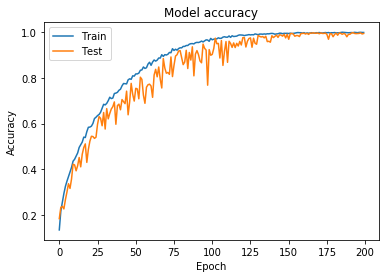

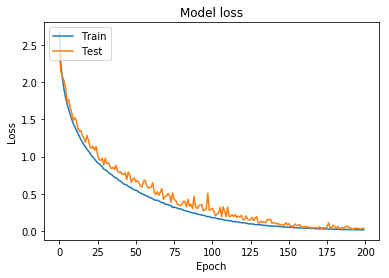

In [14]:
# Plot training & validation accuracy values (of first char only)
plt.plot(history.history['output_0_acc'])
plt.plot(history.history['val_output_0_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values (of first char only)
plt.plot(history.history['output_0_loss'])
plt.plot(history.history['val_output_0_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
nb_words_to_test = 3

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)
print_readable_inputs(x_test)
print("x_test=\n", x_test)

x_test_n  = scaler.transform(x_test)
print("x_test_mean=\n", x_test_n)
print('-->')

prediction = coding_model.predict(x_test_n)
#print(prediction)
print('prediction')
print_readable_outputs(prediction, nb_words_to_test)

print('check prediction')
y_test = encrypt(x_test, nb_words_to_test, nb_chars)
print("y_test=\n", y_test)

['fdfa', 'viyv', 'sbfn']
x_test=
 [[102 100 102  97]
 [118 105 121 118]
 [115  98 102 110]]
x_test_mean=
 [[-0.99908758 -1.26194207 -0.99009764 -1.66466556]
 [ 1.13374959 -0.59515102  1.5349497   1.13819867]
 [ 0.73384262 -1.52865849 -0.99009764  0.07044087]]
-->
prediction
['5-3-5-0-', '21-8-25-21-', '18-1-5-13-']
check prediction
y_test=
 [[ 5  3  5  0]
 [21  8 24 21]
 [18  1  5 13]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
